# Topic Modeling

In [1]:
%matplotlib inline

# filter warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import gensim
import pyLDAvis.gensim_models
from gensim import corpora, models
from gensim.models import CoherenceModel, LdaModel, LdaMulticore
from sklearn.decomposition import LatentDirichletAllocation as LDA

plt.rcParams.update({'font.size': 18})

In [4]:
# import custom class
%run -i '../src/helper/text_preprocessing.py'

In [5]:
# instantiate the class
text_tf = TextPreprocessing()

# Load data

In [6]:
df = pd.read_csv('../data/data_processed.csv', sep = '\t')
print('Data size', df.shape)
cols = ['title', 'abstract', 'authors', 'arXiv_id',  'year']
df[cols].head()

Data size (295174, 20)


,title,abstract,authors,arXiv_id,year
0,Bosonic characters of atomic Cooper pairs acro...,We study the two-particle wave function of p...,"['PongY. H.', 'LawC. K.']",704.0006,2007
1,Numerical solution of shock and ramp compressi...,A general formulation was developed to repre...,['SwiftDamian C.'],704.0008,2007
2,Spectroscopic Properties of Polarons in Strong...,We present recent advances in understanding ...,"[""MishchenkoA. S.CREST, Japan Science and Tech...",704.0025,2007
3,Filling-Factor-Dependent Magnetophonon Resonan...,We describe a peculiar fine structure acquir...,"['GoerbigM. O.', 'FuchsJ. -N.', 'KechedzhiK.',...",704.0027,2007
4,Tuning correlation effects with electron-phono...,We investigate the effect of tuning the phon...,"['HagueJ. P.', ""d'AmbrumenilN.""]",704.003,2007


In [5]:
# extract papers posted on a specific year
year = 2010
df_model = df.copy()[df.year == year].reset_index(drop=True)
print('Data size', df_model.shape)

Data size (13078, 17)


In [6]:
# join the title & abstract
df_model['docs'] = df_model['abstract'] + df_model['title']

# 1. LDA with scikit-learn

In [9]:
# bow vector
X, vocab  = text_tf.bow_vector(df_model, text_col='docs')
print('Data size of bow vector:', X.shape)

Data size of document-term matrix: (13078, 119857)


In [10]:
# LDA with n-topics
lda = LDA(n_components = 20, learning_method = 'batch', random_state = 42) 
lda.fit(X) # fit model
joblib.dump(lda, '../data/lda.pkl') # save trained model
print("LDA model size:", lda.components_.shape)

LDA model size: (20, 119857)


In [11]:
topics = ['topic{}'.format(i) for i in range(lda.components_.shape[0])]
components = pd.DataFrame(lda.components_.T, index=vocab, columns = topics)/len(X)
n_top_words = 10
for i, topic_dist in enumerate(topics):
    topic_words = components[topics[i]].sort_values(ascending = False)[:n_top_words].index
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: phase vortex majorana entropy liquid nonabelian quantum value spectrum scatter
Topic 1: phase transition structure model energy surface band density property polymer
Topic 2: particle system model dynamic transition theory time density phase state
Topic 3: graphene electron transport effect layer energy device electronic tunnel surface
Topic 4: spin model soliton interaction quantum temperature dynamic glass measurement system
Topic 5: quantum system state model spin interaction theory equation dynamic lattice
Topic 6: grain boundary system measure index force order parameter material present
Topic 7: model critical percolation scale system equation exponent distribution method also
Topic 8: field surface scatter electron effect electric state interaction spin increase
Topic 9: state field magnetic model spin quantum effect couple system hall
Topic 10: random polymer walk distribution dynamic method matrix simulation scale analysis
Topic 11: function wave energy equation syste

In [12]:
lda_model = joblib.load('../data/lda.pkl') # load trained LDA model
topic_vector = lda_model.transform(X) # extract the topic vector

In [13]:
# create a dataframe with documents and the corresponding topics
cols = ['topic{}'.format(i) for i in range(lda_model.components_.shape[0])]
df_topic_vec = pd.DataFrame(topic_vector, columns = cols)
df_topic_vec.insert(loc =0, column= 'arXiv_id', value = df_model.arXiv_id)
df_topic_vec.round(2).head(10)

,arXiv_id,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,...,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19
0,1001.0057,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.14,0.85
1,1001.0122,0.00,0.0,0.00,0.37,0.0,0.00,0.0,0.00,0.62,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
2,1001.0214,0.77,0.0,0.00,0.00,0.0,0.15,0.0,0.00,0.00,...,0.0,0.0,0.07,0.0,0.00,0.00,0.00,0.00,0.00,0.00
3,1001.0243,0.00,0.0,0.00,0.00,0.0,0.30,0.0,0.00,0.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.32
4,1001.0246,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,...,0.0,0.3,0.00,0.0,0.06,0.00,0.48,0.15,0.00,0.00
5,1001.0254,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
6,1001.0264,0.00,0.0,0.84,0.00,0.0,0.00,0.0,0.00,0.00,...,0.0,0.0,0.00,0.0,0.00,0.04,0.00,0.00,0.00,0.11
7,1001.0266,0.00,0.0,0.00,0.00,0.0,0.46,0.0,0.00,0.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
8,1001.0270,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.27,0.00,0.37,0.00
9,1001.0271,0.00,0.0,0.13,0.00,0.0,0.23,0.0,0.33,0.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.30


# 2. LDA with gensim

In [14]:
# tokenization
df_model['tokens'] =  df_model['docs'].apply(text_tf.sen_tokenizer)

In [15]:
# add bigrams
df_model['bigram_tokens'] = text_tf.add_bigram(df_model.tokens)
df_model[['docs', 'tokens', 'bigram_tokens']].head()

,docs,tokens,bigram_tokens
0,We present a generic mechanism by which repr...,"[present, generic, mechanism, reproduce, micro...","[present, generic, mechanism, reproduce, micro..."
1,Demonstrating the quantum-confined Stark eff...,"[demonstrate, quantumconfined, stark, effect, ...","[demonstrate, quantumconfined, stark_effect, q..."
2,We have discussed the Tsallis entropy in fin...,"[discuss, tsallis, entropy, finite, nunit, non...","[discuss, tsallis_entropy, finite, nunit, none..."
3,We investigate magnetic response in mesoscop...,"[investigate, magnetic, response, mesoscopic, ...","[investigate, magnetic, response, mesoscopic_r..."
4,A two dimensional flat phononic crystal (PC)...,"[dimensional, flat, phononic, crystal, lens, f...","[dimensional, flat, phononic, crystal, lens, f..."


In [16]:
# create a dictornary, i.e. associate each unique token with unique integer ID
dictionary = corpora.Dictionary(df_model.bigram_tokens)
corpus = [dictionary.doc2bow(text) for text in df_model.bigram_tokens] # bag of words
print('Number of documents: %s'%len(corpus))
print(dictionary)

Number of documents: 13078
Dictionary(123999 unique tokens: ['adiffusivity', 'allows', 'arrestednonequilibrium', 'assume', 'bacteria']...)


In [17]:
tokens_list = df_model.bigram_tokens.values.tolist()
model_list, topic_coherence = text_tf.compute_coherence_lda(
    corpus, dictionary, tokens_list, start=2, limit=40, step=6
    )

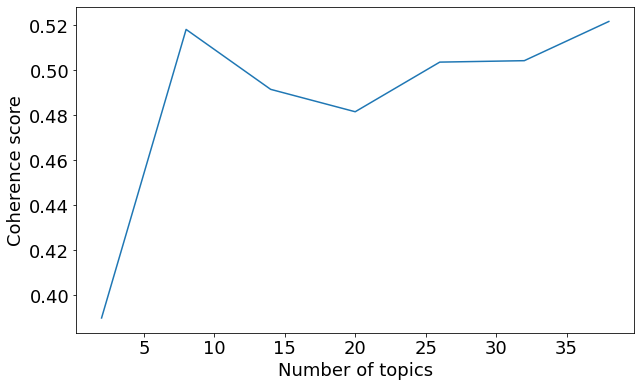

In [18]:
# plot coherence score
num_topics = range(2, 40, 6)
plt.figure(figsize = (10,6))
plt.plot(num_topics, topic_coherence)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.savefig('../images/topic_coherence.png')

In [22]:
for m, cv in zip(num_topics, topic_coherence):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.39
Num Topics = 8  has Coherence Value of 0.5182
Num Topics = 14  has Coherence Value of 0.4916
Num Topics = 20  has Coherence Value of 0.4816
Num Topics = 26  has Coherence Value of 0.5037
Num Topics = 32  has Coherence Value of 0.5043
Num Topics = 38  has Coherence Value of 0.5217


In [25]:
optimal_lda = model_list[2]
optimal_lda.show_topics(num_topics=10, num_words=10)

[(13,
  '0.001*"mutant" + 0.001*"quantizer" + 0.001*"stiff" + 0.001*"fixation" + 0.001*"allele" + 0.001*"writhe" + 0.001*"lammps" + 0.001*"parafermionic" + 0.000*"duality" + 0.000*"biomolecular"'),
 (12,
  '0.001*"thpn" + 0.001*"bitio" + 0.001*"research" + 0.001*"bead" + 0.001*"income" + 0.001*"interedge" + 0.000*"excavate" + 0.000*"archaeological" + 0.000*"hill" + 0.000*"interwall"'),
 (11,
  '0.000*"hmms" + 0.000*"bhnh" + 0.000*"binding_site" + 0.000*"conformer" + 0.000*"conformers" + 0.000*"brown" + 0.000*"stirrup" + 0.000*"hallcrc" + 0.000*"handbook" + 0.000*"chapman"'),
 (10,
  '0.001*"thermostat" + 0.001*"economic" + 0.001*"spread" + 0.001*"message" + 0.001*"acid" + 0.001*"unzip" + 0.001*"begoecs" + 0.001*"crisis" + 0.001*"toluene" + 0.001*"step"'),
 (9,
  '0.001*"nanotubed" + 0.001*"neutron_matter" + 0.001*"htiooh" + 0.000*"fibril" + 0.000*"telegraphlike" + 0.000*"protrusion" + 0.000*"amyloid" + 0.000*"theliquid" + 0.000*"basrtio" + 0.000*"hgte_quantum"'),
 (4,
  '0.001*"znsb" +

In [26]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(optimal_lda, corpus, dictionary,sort_topics=False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.329915 -0.036269       1        1  95.093221
1     -0.061943  0.162358       2        1   1.758805
2      0.005250 -0.054112       3        1   0.781353
3      0.039049 -0.002126       4        1   0.218571
4      0.037517 -0.001448       5        1   0.159204
5      0.012005 -0.039183       6        1   0.713658
6      0.037053 -0.005637       7        1   0.297951
7      0.037773 -0.002038       8        1   0.140832
8      0.037166 -0.005933       9        1   0.191252
9      0.037591 -0.001054      10        1   0.104372
10     0.032412 -0.014685      11        1   0.280803
11     0.038934  0.001033      12        1   0.070608
12     0.039186 -0.000727      13        1   0.084819
13     0.037922 -0.000179      14        1   0.104551, topic_info=                 Term         Freq        Total Category  logprob  loglift
143             state  4657.000000  4657.000000  Default  30.0000  30.0000
50              model  5998.000000  5998.000000  Default  29.0000  29.0000
2254          network   883.000000   883.000000  Default  28.0000  28.0000
304         structure  2290.000000  2290.000000  Default  27.0000  27.0000
1149          process  1159.000000  1159.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
15384     filamentous     0.214394     6.711475  Topic14  -8.3311   3.4195
27619        spinbath     0.200954     5.150267  Topic14  -8.3958   3.6195
12244  solvable_model     0.210426     7.837628  Topic14  -8.3498   3.2457
2798         integral     0.308662   118.162244  Topic14  -7.9666   0.9157
35944      threepoint     0.206051     9.849452  Topic14  -8.3708   2.9962

[792 rows x 6 columns], token_table=        Topic      Freq        Term
term                               
9620        1  0.926965        acid
9620        7  0.026485        acid
9620       11  0.052969        acid
37645       1  0.119589       actin
37645       2  0.777330       actin
...       ...       ...         ...
114921      3  1.023347  znimpurity
104724      5  0.996120        znsb
91718       6  0.893842        znse
91588       6  1.095388        zodd
88093       9  1.111186       zrtio

[916 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])